In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy

In [3]:
# try and load file
gdf = geopd.read_file('./data/Boulder_Area_Trails.geojson') # 'Trails.geojson')
print("Trails: ", gdf.columns)

gdf_small = geopd.read_file('./data/Trails.geojson')
#print("Trails Dissolved: ", gdf.columns)


Trails:  Index(['OBJECTID', 'TRAILNAME', 'ALIAS', 'LENGTH', 'PEDESTRIAN', 'BIKE',
       'HORSE', 'OHV', 'TRAILTYPE', 'SURTYPE', 'STEWARD', 'DATAOWNER',
       'COMMENTS', 'SHAPESTLength', 'DOGS', 'GlobalID', 'BATTrailID',
       'geometry'],
      dtype='object')


In [4]:
for k in gdf.columns:
    print(k, gdf[k][0])

OBJECTID 1
TRAILNAME AHC Trail
ALIAS 
LENGTH 0.5
PEDESTRIAN Yes
BIKE No
HORSE No
OHV No
TRAILTYPE Trail
SURTYPE SoftSurface
STEWARD https://www.bouldercounty.org/open-space/education/museums/agricultural-heritage-center/
DATAOWNER Boulder County Parks and Open Space
COMMENTS dissolved
SHAPESTLength 849.2965328251734
DOGS No
GlobalID {EAC748F1-D30F-4E24-9710-B5C8000BA82A}
BATTrailID BCPOS-1
geometry MULTILINESTRING ((-105.1595259327879 40.20245056543753, -105.1595605107399 40.20238861700264, -105.1595950904884 40.20232666851115, -105.1596177154571 40.20228013403499, -105.1596403395276 40.20223359952695, -105.1596310383711 40.20217470818947, -105.1596217363164 40.20211581611479, -105.1596221297785 40.20203733077622, -105.1596225223422 40.2019588453468, -105.1596356602033 40.20189020894369), (-105.1595259327879 40.20245056543753, -105.1595693214162 40.20249240684255, -105.1595709428752 40.20254771918638, -105.1595565446779 40.20260788360747, -105.1595384993205 40.20266659824025, -105.1595

In [5]:
trail_names_full = gdf.TRAILNAME

In [6]:
trail_names_short = gdf_small.FEATURE_NAME

In [7]:
for k in trail_names_full:
    if not k is None:
        if 'Mud' in k or 'mud' in k:
            print(k)

Mud Lake Connector Trail
Mud Lake Access Trail
Mud Lake Access Trail
Nederland Elem. to Mud Lake
Mud Lake to Hwy. 72


In [8]:
gdf.loc[gdf.TRAILNAME=='Mud Lake Connector Trail']

,OBJECTID,TRAILNAME,ALIAS,LENGTH,PEDESTRIAN,BIKE,HORSE,OHV,TRAILTYPE,SURTYPE,STEWARD,DATAOWNER,COMMENTS,SHAPESTLength,DOGS,GlobalID,BATTrailID,geometry
90,91,Mud Lake Connector Trail,None,0.064478,Yes,Yes,Yes,No,Trail,SoftSurface,https://www.bouldercounty.org/open-space/parks...,Boulder County Parks and Open Space,segmented,135.380251,Yes,{1C256E4A-6B85-4221-8C16-9C584F5B5C8E},BCPOS-95,"LINESTRING (-105.51363 39.97616, -105.51352 39..."


In [9]:
gdf_small.loc[0]

OBJECTID                                                   499057
FEATURE_TYPE                                                    3
LOCATION                                                 Mud Lake
FEATURE_NAME                             Mud Lake Connector Trail
SURFACE_TYPE                                              Natural
WIDTH                                                           3
SOURCE                                                        gps
SRC_YEAR                                                     2004
STATUS                                                   existing
OWNER                                                      County
MAINTENANCE                                                County
ENFORCEMENT                                                County
PED                                                           Yes
BIKE                                                          Yes
HORSE                                                         Yes
DOG       

The key columns here are:

    1) SLength = trail length in feet
    
    2) VerticalGain = gain in feet (*need to update with elevation data for consistency*)
    
    3) Z_Min, Z_Max, Z_Mean = min, max, average altitude *see above*
    
    4) Min_Slope, Max_Slope, Avg_Slope = percent grade *see above*
    
    5) geometry = list of coordinates (as LINESTRING object)... 
                  use LINESTRING.coords to get an iterable over the
                  lat long coordinates as tuples. For whatever reason,
                  this appears to be stored as (long, lat)?!?
                  
                

In [11]:
# try and add in elevation data

elevation_data = srtm.get_data()


I can generate elevations from this data using the below dataset (returns elevation in meters!)

In [12]:
# print(elevation_data.get_elevation(temp.coords[0][1], temp.coords[0][0]))

In [13]:
temp = gdf['geometry'][55]

In [14]:
gdf.loc[55]

OBJECTID                                                        56
TRAILNAME                                       Picture Rock Trail
ALIAS                                                             
LENGTH                                                         5.2
PEDESTRIAN                                                     Yes
BIKE                                                           Yes
HORSE                                                          Yes
OHV                                                             No
TRAILTYPE                                                    Trail
SURTYPE                                                SoftSurface
STEWARD          https://www.bouldercounty.org/open-space/parks...
DATAOWNER                      Boulder County Parks and Open Space
COMMENTS                                                 dissolved
SHAPESTLength                                              10964.5
DOGS                                                          

In [15]:
gpx_data = [None]*len(gdf)

for i in np.arange(len(gdf)):
    gpx_segment = gpxpy.gpx.GPXTrackSegment()    
    try:
        gpx_points = [gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in gdf['geometry'][i].coords]
        
        gpx_segment.points.extend(gpx_points)
        elevation_data.add_elevations(gpx_segment)
    
        gpx_data[i] = gpx_segment        
    except:
        
        # multiple sub-segments
        #   need to stitch these into separate segments
        gpx_data[i] = [None]*len(gdf['geometry'][i])
        #print(len(gdf['geometry'][i]))
        
        for seg_i in np.arange(len(gdf['geometry'][i])):
            
            gpx_segment = gpxpy.gpx.GPXTrackSegment()
            gpx_segment.points.extend([gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in gdf['geometry'][i][seg_i].coords])
            elevation_data.add_elevations(gpx_segment)
            
            gpx_data[i][seg_i] = gpx_segment
        


In [14]:
def get_distances(points):
    """
    Compute distances between gpx points, either as list of 
    GPXTrackPoints from gpxpy OR list of tuples
    """
    
    is_GPX = False
    if not isinstance(points[0],tuple):
        is_GPX=True
        
    if is_GPX:
        p = [(x.latitude,x.longitude,x.elevation) for x in points]
    else:
        p = points
    
    
    distance = np.zeros(len(p)-1)
    for i in np.arange(1, len(p)):
        distance[i-1] = gpxpy.geo.distance(p[i][0],p[i][1],p[i][2],
                                         p[i-1][0],p[i-1][1],p[i-1][2])
        
        
    return distance
 
    

Looking at the below, it looks like the distance between any two contiguous GPS points is 9.094 meters

In [15]:
# find the maximum distances in each segment
all_max = np.zeros(len(gdf))

for i in np.arange(len(gdf)):
    if gpx_data[i] is None:
        all_max[i] = -1
    else:
        all_max[i] = np.max(get_distances(gpx_data[0].points))
        
print(np.min(all_max[all_max>0]), np.max(all_max))

AttributeError: 'list' object has no attribute 'points'

In [ ]:
bad_segments_loc = [55, 272, 299, 317, 326, 342, 386, 416, 420, 421, 438]

max_sub_dist = np.zeros(len(bad_segments_loc))
min_sub_dist = np.zeros(len(bad_segments_loc))

for i, iloc in enumerate(bad_segments_loc):
    
  
    
    # get end coords for first segment
    end_lat, end_long = gdf['geometry'].loc[iloc][0].coords[-1][1],\
                        gdf['geometry'].loc[iloc][0].coords[-1][0]
    
    end_elev = elevation_data.get_elevation(end_lat, end_long)
    
    sub_dist = np.zeros(len(gdf['geometry'].loc[iloc])-1)
    
    loop_count = len(gdf['geometry'].loc[iloc])
    for seg_i in np.arange(1, loop_count):
        
        segment = gdf['geometry'].loc[iloc][seg_i]
        
        # get the first and last end points of next segment
        start_lat, start_long = segment.coords[0][1], segment.coords[0][0]
        start_elev = elevation_data.get_elevation(start_lat, start_long)
        
        print(i,seg_i, end_lat, end_long, start_lat, start_long)

        
        # compute distance
        sub_dist[seg_i-1] = gpxpy.geo.distance(end_lat, end_long, end_elev,
                                         start_lat, start_long, start_elev)
        
        
        end_lat, end_long, end_elev = start_lat*1., start_long*1., start_elev*1.
        
    
    max_sub_dist[i] = np.max(sub_dist)
    min_sub_dist[i] = np.min(sub_dist)

#
# If any of these are below 9.04 we have a problem
#
print("Maximums:")
print(max_sub_dist)
print(np.min(max_sub_dist))
print(np.max(max_sub_dist))

print("Minimums:")
print(min_sub_dist)
print(np.min(min_sub_dist))
print(np.max(min_sub_dist))


/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


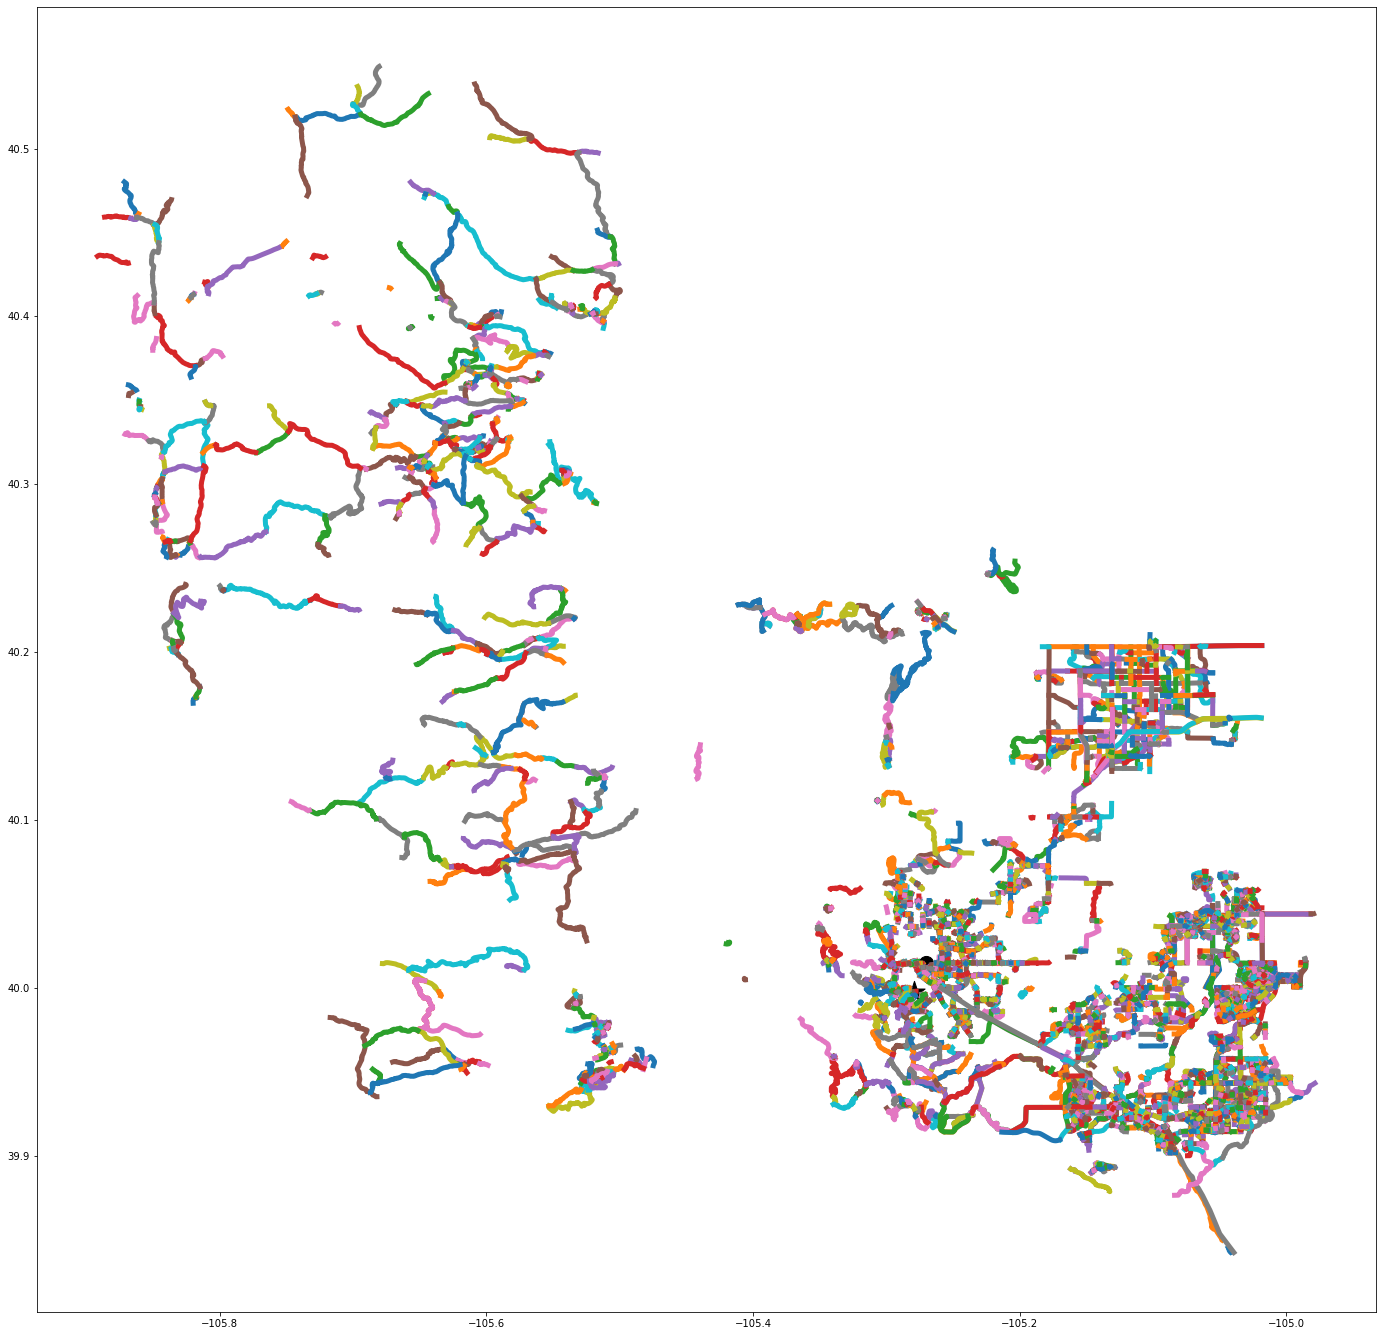

In [16]:
%matplotlib inline


fig, ax = plt.subplots()
fig.set_size_inches(24,24)




#m = Basemap(projection='lcc', resolution='h',
 #           width=8.0E4, height=8.0E4, 
 #           lat_0=40.015, lon_0=-105.2705)
#m.etopo( alpha=0.5)


for i in np.arange(len(gdf)):
    if gpx_data[i] is None:
        print(i)
        continue
        
    elif np.size(gpx_data[i]) == 1:
        data_to_plot = [gpx_data[i]]
    else:
        data_to_plot = gpx_data[i]
        
    for segment in data_to_plot:
    
        lats = np.array([x.latitude for x in segment.points])
        longs = np.array([x.longitude for x in segment.points])
        elev = np.array([x.elevation for x in segment.points])
        ax.plot(longs,lats,lw=5)
    
ax.scatter(-105.2705,40.015, color = 'black', s = 200)
chataqua = (-105.2795, 39.9972)
ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 500)


sep = 0.025
#ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
#ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
fig.show()

In [1]:
%matplotlib widget
import contextily as ctx
gdf_crs = gdf.copy().to_crs(epsg=3857)
ax = gdf_crs.plot()
ax.figure.set_size_inches(16,16)
ctx.add_basemap(ax)
ax.figure.show()

NameError: name 'gdf' is not defined

In [29]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich